<img src="https://iteso.mx/documents/27014/202031/Logo-ITESO-MinimoH.png"
     align="right"
     width="300"/>

# Modelos ARIMA

## *Modelos no lineales para pronósitico*  - Pedro Martinez

### Equipo: Rocha, Rafa, Roi, Ivan (RRRi)

---

## **<font color= #0077b6> Objetivos de la Práctica </font>**
1.  Conectar e ingerir datos financieros/económicos reales mediante la API de la Reserva Federal (FRED).
2.  Analizar la estacionariedad de la serie (Prueba de Dickey-Fuller Aumentada).
3.  Implementar la metodología Box-Jenkins para la selección del orden $(p,d,q)$.
4.  Utilizar `pmdarima` para la optimización automática de hiperparámetros basada en Criterios de Información (AIC).
5.  Generar pronósticos y visualizarlos interactivamente con `plotly`.

## **<font color= #0077b6> Fundamento Matemático: Modelo ARIMA** </font>

Un modelo ARIMA se define por tres parámetros $(p, d, q)$. Matemáticamente, para una serie de tiempo $y_t$, el modelo se expresa utilizando el operador de rezago (Backshift operator) $B$, donde $B y_t = y_{t-1}$.

La forma canónica es:

$$\phi_p(B) (1 - B)^d Y_t = c + \theta_q(B) \epsilon_t$$

Donde:
* $\phi_p(B) = 1 - \phi_1 B - ... - \phi_p B^p$ es la parte Auto Regresiva (AR).
* $(1 - B)^d$ representa las **d** diferencias necesarias para hacer la serie estacionaria (I).
* $\theta_q(B) = 1 + \theta_1 B + ... + \theta_q B^q$ es la parte de Media Móvil (MA).
* $\epsilon_t$ es un proceso de ruido blanco con media 0 y varianza $\sigma^2$.

El objetivo es encontrar la combinación de parámetros que minimice el Criterio de Información de Akaike (AIC)



## **<font color= #0077b6> Índice S&P/Case-Shiller </font>**

Para esta práctica, analizaremos la serie de tiempo `CSUSHPINSA` obtenida de la Reserva Federal (FRED).

¿Qué es?

Se trata del **S&P/Case-Shiller U.S. National Home Price Index**. Es el principal indicador macroeconómico para medir el cambio en el valor del mercado de bienes raíces residencial en USA.

¿Por qué usamos esta serie?
1.  **Tendencia Estocástica:** Presenta una tendencia clara (crecimiento a largo plazo) que no es lineal, requiriendo diferenciación ($d$).
2.  **No Estacionalidad Ajustada (NSA):** Al usar la versión *Not Seasonally Adjusted*, la serie contiene "ruido" y patrones cíclicos naturales que el modelo debe intentar capturar a través de sus componentes autoregresivos ($p$) y de media móvil ($q$).

In [2]:
# @title Instalación de Librerías y Configuración
# Instalamos fredapi para datos y pmdarima para el auto-tuning del modelo
!pip install fredapi plotly statsmodels --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from fredapi import Fred
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Configuración de gráficos
plt.style.use('ggplot')

In [3]:
# @title Conexión a FRED (Federal Reserve Economic Data)


# IMPORTANTE:
# Puedes obtener API KEY en: https://fred.stlouisfed.org/docs/api/api_key.html
# La guardas como secret
# from google.colab import userdata

import os
from dotenv import load_dotenv

load_dotenv()  # Carga las variables de entorno desde el archivo .env   
API_KEY = os.getenv('API_KEY') # Aqui pon tu API

try:
    fred = Fred(api_key=API_KEY)

    # Usaremos 'CSUSHPINSA': Índice de Precios de Vivienda Case-Shiller (S&P)
    # Es una serie muy buena para ver tendencias claras.
    series_id = 'CSUSHPINSA'
    df = pd.DataFrame(fred.get_series(series_id), columns=['value'])
    df.index.name = 'date'

    # Filtramos datos desde el año 2010 para un análisis más reciente
    df = df[df.index >= '2010-01-01']

    # IMPORTANTE: Establecemos la frecuencia explícita (Mensual - Inicio)
    df.index = pd.DatetimeIndex(df.index).to_period('M').to_timestamp()
    df.index.freq = 'MS'

except Exception as e:
    print(f"Error: {e}")

fig = px.line(df, x=df.index, y='value', title=f'Serie de Tiempo: {series_id}')
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Índice',

)
fig.show()

In [4]:
# @title Prueba de Dickey-Fuller y Diferenciación
def check_stationarity(series, title="Serie Original"):
    result = adfuller(series.dropna())
    print(f'ADF Test: {title}')
    print(f'Estadístico ADF: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    is_stationary = result[1] < 0.05
    print(f"¿Es estacionaria? {'SÍ' if is_stationary else 'NO'}\n")
    return is_stationary

# 1. Revisamos la serie original
check_stationarity(df['value'], "Nivel Original")

# 2. Aplicamos Primera Diferencia (d=1)
df['diff_1'] = df['value'].diff()

# 3. Revisamos la serie diferenciada
check_stationarity(df['diff_1'], "Primera Diferencia (d=1)")

# Creamos una figura con 2 columnas (Subplots)
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Serie Original (No Estacionaria)", "Serie Diferenciada (Estacionaria d=1)")
)

# Gráfico 1: Serie Original
fig.add_trace(
    go.Scatter(x=df.index, y=df['value'], name='Original'),
    row=1, col=1
)

# Gráfico 2: Serie Diferenciada
fig.add_trace(
    go.Scatter(x=df.index, y=df['diff_1'], name='Diferenciada'),
    row=1, col=2
)

# Ajustes de diseño
fig.update_layout(
    title_text="Comparativa: Efecto de la Diferenciación",
    showlegend=False, # Ocultamos leyenda
    height=500
)

fig.show()

ADF Test: Nivel Original
Estadístico ADF: -0.3848
p-value: 0.9126
¿Es estacionaria? NO

ADF Test: Primera Diferencia (d=1)
Estadístico ADF: -2.9937
p-value: 0.0355
¿Es estacionaria? SÍ



## Identificación de Órdenes (p, q)

Para seleccionar los términos AR y MA, analizamos los correlogramas de la serie diferenciada/estacionaria.

* **ACF (Función de Autocorrelación):** Nos ayuda a identificar el orden de Media Móvil (**q**). Buscamos el último lag significativo fuera de las bandas de confianza.
* **PACF (Autocorrelación Parcial):** Nos ayuda a identificar el orden Auto Regresivo (**p**).

Sugerencia:
* Si PACF cae abruptamente después del lag $p$ y ACF decae suavemente: Modelo AR($p$).
* Si ACF cae abruptamente después del lag $q$ y PACF decae suavemente: Modelo MA($q$).

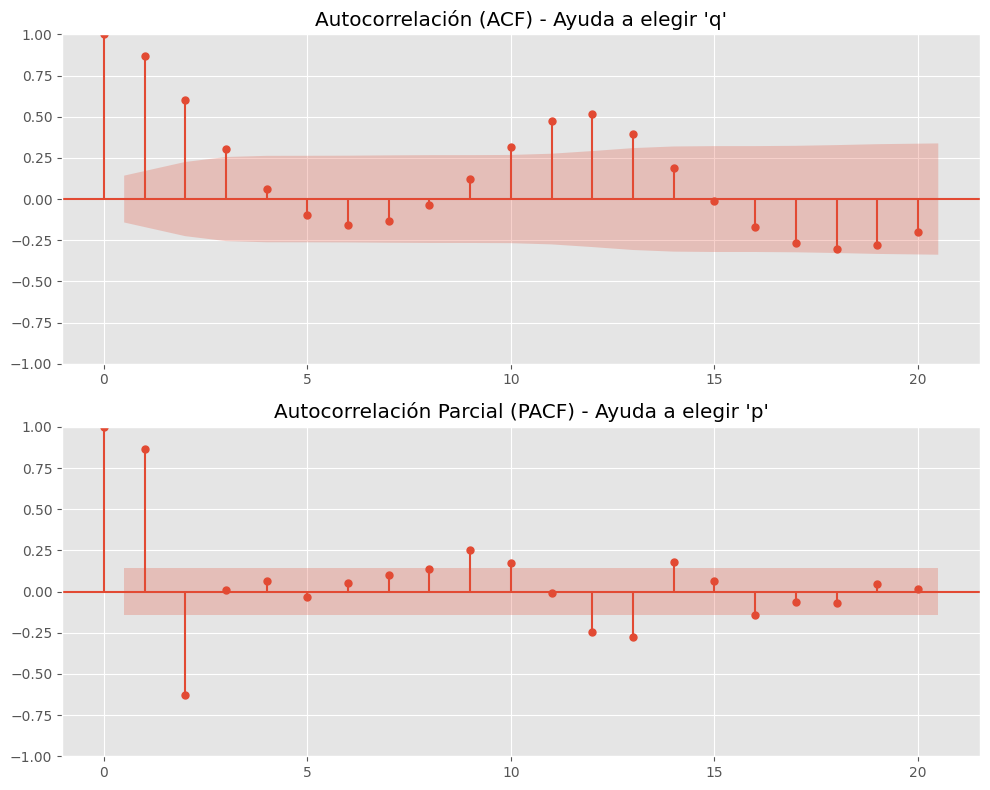

In [5]:
# @title Gráficos ACF y PACF
# IMPORTANTE: Usamos la serie diferenciada
series_analysis = df['diff_1'].dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Graficamos ACF (para q)
plot_acf(series_analysis, lags=20, ax=ax1, title="Autocorrelación (ACF) - Ayuda a elegir 'q'")

# Graficamos PACF (para p)
plot_pacf(series_analysis, lags=20, ax=ax2, title="Autocorrelación Parcial (PACF) - Ayuda a elegir 'p'")

plt.tight_layout()
plt.show()

In [15]:
# @title Realizar modelo ARIMA


# Definimos el tamaño del test
test_size = 6

# Separamos los datos
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]


# Ajustamos el modelo ARIMA
# Nota: Statsmodels maneja la diferenciación (d=1) internamente.
model = ARIMA(train['value'], order=(4, 1, 2))
results = model.fit()
print(results.summary())

# Realizamos el pronóstico para los pasos del Test set
# start: índice donde empieza el test, end: índice donde termina
forecast_object = results.get_forecast(steps=len(test))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int(alpha=0.05) # 95% confianza

# Convertimos a DataFrame para facilitar el manejo
forecast_df = pd.DataFrame({
    'date': test.index,
    'actual': test['value'],
    'forecast': forecast.values,
    'lower_ci': conf_int.iloc[:, 0].values,
    'upper_ci': conf_int.iloc[:, 1].values
})
forecast_df.set_index('date', inplace=True)

# Cálculo de Métricas de Error
rmse = np.sqrt(mean_squared_error(test['value'], forecast))
mae = mean_absolute_error(test['value'], forecast)
print(f"\n--- Métricas de Evaluación en Test Set ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


fig = go.Figure()
# Datos de Entrenamiento (Histórico)
# Mostramos solo los últimos años para que se vea bien el detalle del final
train_subset = train[train.index > '2018-01-01']

fig.add_trace(go.Scatter(
    x=train_subset.index, y=train_subset['value'],
    mode='lines', name='Train',
    line=dict(color='gray')
))

# Datos Reales (Test)
fig.add_trace(go.Scatter(
    x=test.index, y=test['value'],
    mode='lines+markers', name='Test',
    line=dict(color='green', width=2)
))

# Pronóstico del Modelo
fig.add_trace(go.Scatter(
    x=forecast_df.index, y=forecast_df['forecast'],
    mode='lines+markers', name='ARIMA',
    line=dict(color='red', dash='dash', width=2)
))

# Intervalos de Confianza
fig.add_trace(go.Scatter(
    x=forecast_df.index.tolist() + forecast_df.index[::-1].tolist(),
    y=forecast_df['upper_ci'].tolist() + forecast_df['lower_ci'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.15)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Intervalo de Confianza (95%)',
    hoverinfo="skip"
))

fig.update_layout(
    title='Real vs Forecast',
    xaxis_title='Fecha',
    yaxis_title='Indice',
    hovermode="x unified",
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

c:\Users\ivanm\6toSemestre\modelos_no_lineales\arima_models\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\ivanm\6toSemestre\modelos_no_lineales\arima_models\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  185
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -165.676
Date:                Mon, 09 Feb 2026   AIC                            345.353
Time:                        21:11:47   BIC                            367.857
Sample:                    01-01-2010   HQIC                           354.474
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2521      0.429      2.919      0.004       0.411       2.093
ar.L2         -0.3891      0.855     -0.455      0.649      -2.065       1.286
ar.L3         -0.1383      0.705     -0.196      0.8

In [16]:
try:
    fred = Fred(api_key=API_KEY)

    # Usaremos 'TRESEGMXM052N': Índice de Precios de Vivienda Case-Shiller (S&P)
    # Es una serie muy buena para ver tendencias claras.
    series_id = 'TRESEGMXM052N'
    df = pd.DataFrame(fred.get_series(series_id), columns=['value'])
    df.index.name = 'date'

    # Filtramos datos desde el año 2010 para un análisis más reciente
    df = df[df.index >= '2010-01-01']

    # IMPORTANTE: Establecemos la frecuencia explícita (Mensual - Inicio)
    df.index = pd.DatetimeIndex(df.index).to_period('M').to_timestamp()
    df.index.freq = 'MS'

except Exception as e:
    print(f"Error: {e}")

fig = px.line(df, x=df.index, y='value', title=f'Serie de Tiempo: {series_id}')
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Índice',

)
fig.show()

In [21]:
# @title Prueba de Dickey-Fuller y Diferenciación
def check_stationarity(series, title="Serie Original"):
    result = adfuller(series.dropna())
    print(f'ADF Test: {title}')
    print(f'Estadístico ADF: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    is_stationary = result[1] < 0.05
    print(f"¿Es estacionaria? {'SÍ' if is_stationary else 'NO'}\n")
    return is_stationary

# 1. Revisamos la serie original
check_stationarity(df['value'], "Nivel Original")

# 2. Aplicamos Primera Diferencia (d=1)
df['diff_1'] = df['value'].diff()

# 3. Revisamos la serie diferenciada
check_stationarity(df['diff_1'], "Primera Diferencia (d=1)")

# 4. Aplicamos Segunda Diferencia (d=2)
df['diff_2'] = df['diff_1'].diff()

# 5. Revisamos la serie diferenciada (d=2)
check_stationarity(df['diff_2'], "Segunda Diferencia (d=2)")

# Creamos una figura con 2 columnas (Subplots)
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Serie Original (No Estacionaria)", "Serie Diferenciada (Estacionaria d=1)", "Serie Diferenciada (d=2)")
)

# Gráfico 1: Serie Original
fig.add_trace(
    go.Scatter(x=df.index, y=df['value'], name='Original'),
    row=1, col=1
)

# Gráfico 2: Serie Diferenciada
fig.add_trace(
    go.Scatter(x=df.index, y=df['diff_1'], name='Diferenciada'),
    row=1, col=2
)

# Gráfico 2: Serie Diferenciada
fig.add_trace(
    go.Scatter(x=df.index, y=df['diff_2'], name='Diferenciada (2)'),
    row=2, col=1
)

# Ajustes de diseño
fig.update_layout(
    title_text="Comparativa: Efecto de la Diferenciación",
    showlegend=False, # Ocultamos leyenda
    height=500
)

fig.show()

ADF Test: Nivel Original
Estadístico ADF: -0.9729
p-value: 0.7630
¿Es estacionaria? NO

ADF Test: Primera Diferencia (d=1)
Estadístico ADF: -2.7154
p-value: 0.0714
¿Es estacionaria? NO

ADF Test: Segunda Diferencia (d=2)
Estadístico ADF: -7.4735
p-value: 0.0000
¿Es estacionaria? SÍ



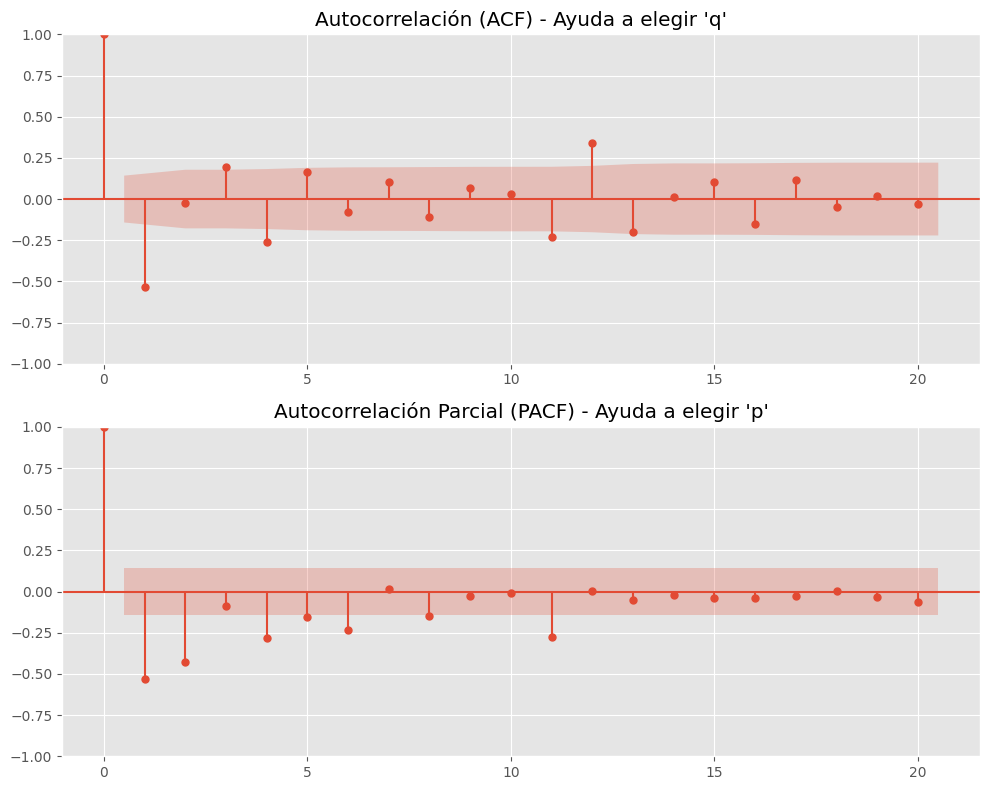

In [22]:
# @title Gráficos ACF y PACF
# IMPORTANTE: Usamos la serie diferenciada
series_analysis = df['diff_2'].dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Graficamos ACF (para q)
plot_acf(series_analysis, lags=20, ax=ax1, title="Autocorrelación (ACF) - Ayuda a elegir 'q'")

# Graficamos PACF (para p)
plot_pacf(series_analysis, lags=20, ax=ax2, title="Autocorrelación Parcial (PACF) - Ayuda a elegir 'p'")

plt.tight_layout()
plt.show()

In [ ]:
# @title Realizar modelo ARIMA (2,2,1)


# Definimos el tamaño del test
test_size = 6

# Separamos los datos
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]


# Ajustamos el modelo ARIMA
# Nota: Statsmodels maneja la diferenciación (d=1) internamente.
model = ARIMA(train['value'], order=(2, 2, 1))
results = model.fit()
print(results.summary())

# Realizamos el pronóstico para los pasos del Test set
# start: índice donde empieza el test, end: índice donde termina
forecast_object = results.get_forecast(steps=len(test))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int(alpha=0.05) # 95% confianza

# Convertimos a DataFrame para facilitar el manejo
forecast_df = pd.DataFrame({
    'date': test.index,
    'actual': test['value'],
    'forecast': forecast.values,
    'lower_ci': conf_int.iloc[:, 0].values,
    'upper_ci': conf_int.iloc[:, 1].values
})
forecast_df.set_index('date', inplace=True)

# Cálculo de Métricas de Error
rmse = np.sqrt(mean_squared_error(test['value'], forecast))
mae = mean_absolute_error(test['value'], forecast)
mape = np.mean(np.abs((test['value'] - forecast) / test['value'])) * 100
print(f"\n--- Métricas de Evaluación en Test Set ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")



fig = go.Figure()
# Datos de Entrenamiento (Histórico)
# Mostramos solo los últimos años para que se vea bien el detalle del final
train_subset = train[train.index > '2018-01-01']

fig.add_trace(go.Scatter(
    x=train_subset.index, y=train_subset['value'],
    mode='lines', name='Train',
    line=dict(color='gray')
))

# Datos Reales (Test)
fig.add_trace(go.Scatter(
    x=test.index, y=test['value'],
    mode='lines+markers', name='Test',
    line=dict(color='green', width=2)
))

# Pronóstico del Modelo
fig.add_trace(go.Scatter(
    x=forecast_df.index, y=forecast_df['forecast'],
    mode='lines+markers', name='ARIMA',
    line=dict(color='red', dash='dash', width=2)
))

# Intervalos de Confianza
fig.add_trace(go.Scatter(
    x=forecast_df.index.tolist() + forecast_df.index[::-1].tolist(),
    y=forecast_df['upper_ci'].tolist() + forecast_df['lower_ci'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.15)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Intervalo de Confianza (95%)',
    hoverinfo="skip"
))

fig.update_layout(
    title='Real vs Forecast',
    xaxis_title='Fecha',
    yaxis_title='Indice',
    hovermode="x unified",
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  186
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1735.434
Date:                Mon, 09 Feb 2026   AIC                           3478.868
Time:                        21:36:11   BIC                           3491.728
Sample:                    01-01-2010   HQIC                          3484.080
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5704      0.042     13.675      0.000       0.489       0.652
ar.L2         -0.0193      0.024     -0.805      0.421      -0.066       0.028
ma.L1         -0.9327      0.040    -23.340      0.0

In [28]:
# @title Realizar modelo ARIMA (4,2,1)


# Definimos el tamaño del test
test_size = 6

# Separamos los datos
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]


# Ajustamos el modelo ARIMA
# Nota: Statsmodels maneja la diferenciación (d=1) internamente.
model = ARIMA(train['value'], order=(4, 3, 3))
results = model.fit()
print(results.summary())

# Realizamos el pronóstico para los pasos del Test set
# start: índice donde empieza el test, end: índice donde termina
forecast_object = results.get_forecast(steps=len(test))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int(alpha=0.05) # 95% confianza

# Convertimos a DataFrame para facilitar el manejo
forecast_df = pd.DataFrame({
    'date': test.index,
    'actual': test['value'],
    'forecast': forecast.values,
    'lower_ci': conf_int.iloc[:, 0].values,
    'upper_ci': conf_int.iloc[:, 1].values
})
forecast_df.set_index('date', inplace=True)

# Cálculo de Métricas de Error
rmse = np.sqrt(mean_squared_error(test['value'], forecast))
mae = mean_absolute_error(test['value'], forecast)
mape = np.mean(np.abs((test['value'] - forecast) / test['value'])) * 100
print(f"\n--- Métricas de Evaluación en Test Set ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")



fig = go.Figure()
# Datos de Entrenamiento (Histórico)
# Mostramos solo los últimos años para que se vea bien el detalle del final
train_subset = train[train.index > '2018-01-01']

fig.add_trace(go.Scatter(
    x=train_subset.index, y=train_subset['value'],
    mode='lines', name='Train',
    line=dict(color='gray')
))

# Datos Reales (Test)
fig.add_trace(go.Scatter(
    x=test.index, y=test['value'],
    mode='lines+markers', name='Test',
    line=dict(color='green', width=2)
))

# Pronóstico del Modelo
fig.add_trace(go.Scatter(
    x=forecast_df.index, y=forecast_df['forecast'],
    mode='lines+markers', name='ARIMA',
    line=dict(color='red', dash='dash', width=2)
))

# Intervalos de Confianza
fig.add_trace(go.Scatter(
    x=forecast_df.index.tolist() + forecast_df.index[::-1].tolist(),
    y=forecast_df['upper_ci'].tolist() + forecast_df['lower_ci'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.15)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Intervalo de Confianza (95%)',
    hoverinfo="skip"
))

fig.update_layout(
    title='Real vs Forecast',
    xaxis_title='Fecha',
    yaxis_title='Indice',
    hovermode="x unified",
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

c:\Users\ivanm\6toSemestre\modelos_no_lineales\arima_models\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  186
Model:                 ARIMA(4, 3, 3)   Log Likelihood               -1714.912
Date:                Mon, 09 Feb 2026   AIC                           3445.824
Time:                        21:43:07   BIC                           3471.500
Sample:                    01-01-2010   HQIC                          3456.232
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.3103      0.070    -32.991      0.000      -2.448      -2.173
ar.L2         -2.0199      0.143    -14.172      0.000      -2.299      -1.741
ar.L3         -0.6633      0.116     -5.739      0.0

c:\Users\ivanm\6toSemestre\modelos_no_lineales\arima_models\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

